- 2012 ImageNei竞赛
- 更深更大的LeNet
- 改进：
    丢弃法，ReLU, AvgPooling—>MaxPooling，数据增强

- 观念的改变
    + 人工特征提取——>SVM
    + CNN学习特征——>softmax回归

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


## 网络构建

In [2]:
net = nn.Sequential(
    # 相比LeNet，使用一个11*11的更大窗口来捕捉对象。
    # 步幅为4，以减少输出高宽。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

## 观察每一层形状

In [7]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    if type(layer)==nn.Conv2d or type(layer)==nn.Linear or type(layer)==nn.MaxPool2d:
        print(layer)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d 

## 读取数据集

尽管本文中AlexNet是在ImageNet上进行训练的，但我们在这里使用的是Fashion-MNIST数据集。因为即使在现代GPU上，训练ImageNet模型，同时使其收敛可能需要数小时或数天的时间。
将AlexNet直接应用于Fashion-MNIST的一个问题是，[**Fashion-MNIST图像的分辨率**]（$28 \times 28$像素）(**低于ImageNet图像。**)
为了解决这个问题，(**我们将它们增加到$224 \times 224$**)（通常来讲这不是一个明智的做法，但我们在这里这样做是为了有效使用AlexNet架构）。
我们使用`d2l.load_data_fashion_mnist`函数中的`resize`参数执行此调整。


In [9]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.432, train acc 0.842, test acc 0.847
224.4 examples/sec on cuda:0


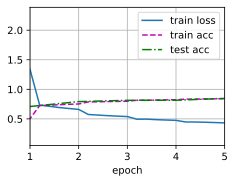

In [10]:
lr, num_epochs = 0.01, 5
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())